<a href="https://colab.research.google.com/github/varshacvenkat-web/Varsha-Venkatapathy-Engineering-Portfolio-/blob/main/Ultrasound_Tumor_Detection_Code_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Dataset_BUSI



Dataset_BUSI_with_GT


In [ ]:
!ls /content/drive/MyDrive/Dataset_BUSI/Dataset_BUSI_with_GT


benign	malignant  normal


In [ ]:
import os, shutil, random

# 1.  raw BUSI lives:
original_dir = '/content/drive/MyDrive/Dataset_BUSI/Dataset_BUSI_with_GT'

# 2. train/val/test splits:
output_base = '/content/data/BUSI'

# 3. Define categories and split ratios:
categories = ['benign', 'malignant']
splits     = ['train', 'validation', 'test']
ratios     = {'train': 0.6, 'validation': 0.2, 'test': 0.2}

# 4. Create the output folders:
for split in splits:
    for cat in categories:
        os.makedirs(os.path.join(output_base, split, cat), exist_ok=True)

# 5. Shuffle & copy:
for cat in categories:
    src_folder = os.path.join(original_dir, cat)
    imgs = [f for f in os.listdir(src_folder) if f.lower().endswith('.png') and '_mask' not in f]
    random.shuffle(imgs)
    n = len(imgs)
    n1 = int(ratios['train'] * n)
    n2 = int(ratios['validation'] * n)
    subsets = {
        'train': imgs[:n1],
        'validation': imgs[n1:n1+n2],
        'test': imgs[n1+n2:]
    }
    for split, files in subsets.items():
        for fn in files:
            shutil.copy(os.path.join(src_folder, fn),
                        os.path.join(output_base, split, cat, fn))

# 6. Confirm the counts:
print("Done! Here’s what you have:")
for split in splits:
    for cat in categories:
        cnt = len(os.listdir(os.path.join(output_base, split, cat)))
        print(f"  {split}/{cat}: {cnt}")


Done! Here’s what you have:
  train/benign: 262
  train/malignant: 126
  validation/benign: 87
  validation/malignant: 42
  test/benign: 88
  test/malignant: 42


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/data/BUSI'
img_size = (224, 224)
batch_size = 8

# Augment & rescale for training
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    f'{base_dir}/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Only rescale for validation & test
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    f'{base_dir}/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    f'{base_dir}/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 388 images belonging to 2 classes.
Found 129 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Use MobileNetV2 for quick prototyping
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_gen,
    epochs=3,
    validation_data=val_gen
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 780ms/step - accuracy: 0.4866 - loss: 0.7341 - val_accuracy: 0.6357 - val_loss: 0.6406
Epoch 2/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 587ms/step - accuracy: 0.6357 - loss: 0.6447 - val_accuracy: 0.6434 - val_loss: 0.6213
Epoch 3/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 658ms/step - accuracy: 0.6451 - loss: 0.6200 - val_accuracy: 0.6279 - val_loss: 0.6049


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
import time

# Time the predictions
start = time.time()
preds = model.predict(test_gen, verbose=0)
inference_time = (time.time() - start) / len(preds)

y_true = test_gen.classes[:len(preds)]
y_pred = preds.ravel()

accuracy = np.mean((y_pred > 0.5) == y_true)
auc = roc_auc_score(y_true, y_pred)

print(f"Prelim Test Accuracy: {accuracy:.2f}")
print(f"Prelim Test AUC:      {auc:.2f}")
print(f"Prelim Inference:     {inference_time:.3f} s/image")


Prelim Test Accuracy: 0.65
Prelim Test AUC:      0.55
Prelim Inference:     0.111 s/image


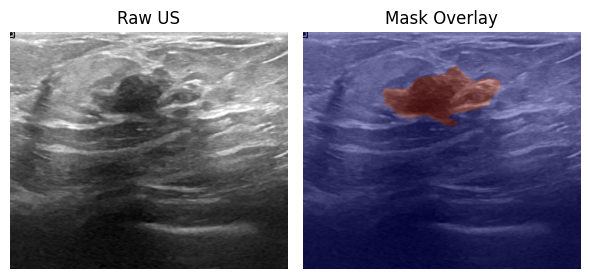

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Adjust to where BUSI GT files
base_path = '/content/drive/MyDrive/Dataset_BUSI/Dataset_BUSI_with_GT'
cat = 'malignant'
files = [f for f in os.listdir(os.path.join(base_path, cat)) if f.endswith('.png') and '_mask' not in f]
sample = files[0]
img = Image.open(os.path.join(base_path, cat, sample)).convert('L')
mask = Image.open(os.path.join(base_path, cat, f"{os.path.splitext(sample)[0]}_mask.png")).convert('L')

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray'); plt.title('Raw US'); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='jet', alpha=0.4)
plt.title('Mask Overlay'); plt.axis('off')
plt.tight_layout()
plt.show()
